In [ ]:
import os
import pickle as pkl
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_utils import (
    results2df,
    return_ct_location_segments,
    return_sorted_heatmap,
)

In [ ]:
train_results = "../dataset/results/training_progression/train/model=slow_r50_feats=epoch-100_split=train.pkl"
val_results = "../dataset/results/training_progression/validation/model=slow_r50_feats=epoch-100_split=val.pkl"
metadata_file = "../dataset/metadata/metadata.csv"
behaviours_file = "../dataset/metadata/behaviours.txt"
segments_file = "../dataset/metadata/segments.txt"

with open(train_results, "rb") as f:
    train_data = pkl.load(f)

with open(
    val_results,
    "rb",
) as f:
    val_data = pkl.load(f)

metadata_df = pd.read_csv(metadata_file)

with open(behaviours_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segments_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

In [ ]:
train_df, val_df = results2df(train_data, val_data, metadata_df)

In [ ]:
train_hm = return_sorted_heatmap(train_df, normalize=True)
val_hm = return_sorted_heatmap(val_df, normalize=True)

# Filter train locs not seen during validation
train_hm = train_hm.merge(val_hm["utm"], on="utm", how="right")

# Create location count to sort all dfs by train loc count
count_df = (
    train_df.utm.value_counts()
    .reset_index()
    .rename(columns={"index": "utm", "utm": "loc_count"})
)

val_hm = val_hm.merge(count_df, on="utm", how="left").sort_values(
    by="loc_count", ascending=False
)
train_hm = train_hm.merge(count_df, on="utm", how="left").sort_values(
    by="loc_count", ascending=False
)

In [ ]:
def plot_heatmap(df, annot=False, yticklabels=None, xticklabels=False):
    fig = plt.figure(figsize=(50, 10))

    sns.heatmap(
        df.drop(columns=["loc_count"]).set_index("utm").transpose(),
        annot=annot,
        fmt=".2f",
        cmap="YlOrRd",
        cbar_kws={"label": "Proportion of Videos"},
        yticklabels=yticklabels,
        xticklabels=xticklabels,
        linecolor="black",
    )

    plt.title(
        "Proportion of Videos per Class by UTM Location\n(Sorted by Total Video Count)",
        fontsize=16,
    )
    plt.xlabel("UTM Location", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_heatmap(train_hm, annot=False, yticklabels=behaviours)

**Create ordered list of camera locations**

In [44]:
for i in range(len(train_hm)):
    assert train_hm.utm.values[i] == val_hm.utm.values[i]

train_hm.utm.to_csv(
    "../dataset/metadata/ordered_locations.txt", index=False, header=False
)

**Val/Train Loc**

In [47]:
div_df = (val_hm.set_index("utm") / train_hm.set_index("utm")).reset_index()

# Replace inf and -inf with nan
div_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill nan with 0
div_df.fillna(0, inplace=True)

# Merge location count for ordering
div_df = div_df.merge(
    val_df.utm.value_counts()
    .reset_index()
    .rename(columns={"index": "utm", "utm": "location_count"}),
    on="utm",
    how="left",
).sort_values("location_count", ascending=False)

# Drop rows in val but not train
div_df.dropna(inplace=True)

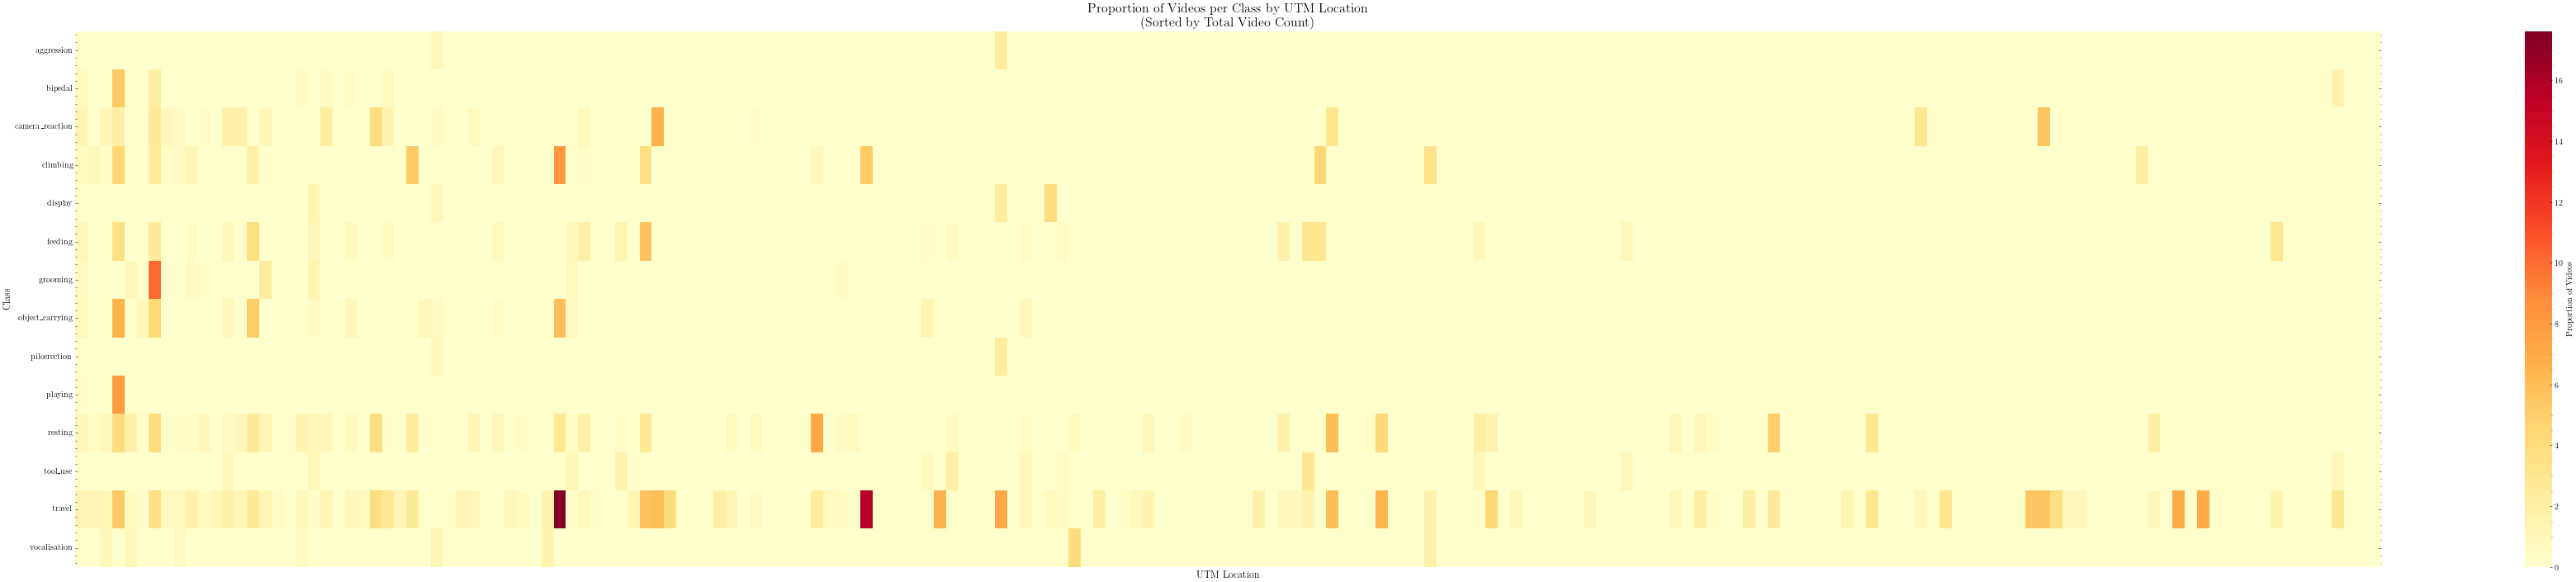

In [48]:
plot_heatmap(
    div_df.drop(columns=["location_count"]), annot=False, yticklabels=behaviours
)